In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

from datetime import datetime
from os import path, environ

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipyvolume as ipv

from preprocess import POW_FIELDS, TEMP_FIELDS
from thermo import CONSTANTS
from plotting import animate_dataframes
# source file, see docs/5-dataset.md for info on field names
chiller_file = path.join(environ['DATADIR'], 'EngineeringScienceBuilding', 'Chillers.csv')
plot_path = path.join('..', 'docs', 'img')

# Trends

## Dataset

The dataset describes input/output powers, temperatures, and cooling by various components of a chiller with a water-cooled condenser and a cooling tower. More details are in `/docs/`.

After pre-processing, all measurements are in SI units (Kelvins, watts) except for the field `KWPerTon` where units are explicit in the measurement.

In [2]:
# Read pre-processed data
df = pd.read_csv(chiller_file, index_col='Time', parse_dates=True, dtype=float)
df.dropna(inplace=True)
print('{} rows, {} columns'.format(len(df), len(df.columns)))
df.head()

103258 rows, 20 columns


,FlowEvap,FreqFanA,FreqFanB,PerChiLoad,PerFreqFanA,PerFreqFanB,PerHumidity,PowChi,PowChiP,PowConP,PowCool,PowFanA,PowFanB,PowIn,TempAmbient,TempCondIn,TempCondOut,TempEvapIn,TempEvapOut,TempWetBulb
Time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.003912,0.003912,0.626527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.683475,290.49,290.07,286.04,284.58,261.746306
2018-01-01 00:05:00,0.0,0.0,0.0,0.0,0.003912,0.003912,0.642870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.578395,290.48,290.11,286.04,284.57,261.696383
2018-01-01 00:10:00,0.0,0.0,0.0,0.0,0.003912,0.003912,0.645108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.520320,290.48,290.06,286.04,284.56,261.649772
2018-01-01 00:15:00,0.0,0.0,0.0,0.0,0.003912,0.003912,0.648744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.510711,290.47,290.10,286.04,284.57,261.651572
2018-01-01 00:20:00,0.0,0.0,0.0,0.0,0.003912,0.003912,0.642590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.664918,290.47,290.09,286.04,284.57,261.774611


## Efficiency metrics

### Coefficient of performance

$$
\begin{align*}
COP_{max cooling} &= \frac{T_{cold}}{T_{hot} - T_{cold}}  \\
COP &= \frac{\texttt{Energy Extracted}}{\texttt{Energy Input}}
\end{align*}
$$

In [3]:
# Measure maximum Coefficient of Performance (COP) for cooling
# for the ENTIRE chiller plant.
# Currently in the dataset, water flow rate for the condenser loop
# is not available - so COP for condenser/cooling tower cannot be
# calculated.
df['COPMax'] = df['TempEvapIn'] / (df['TempEvapIn'] - df['TempEvapOut'])

# Measured achieved COP
df['COP'] = df['PowCool'] / df['PowIn']

In [4]:
# Aggregating measurements across days by time of day
df = df[~df.index.duplicated(keep='first')]          # temporary fix to ignore duplicate timestamps
downsampled = df.asfreq('15T')                       # downsampling to 15 min for cleaner plot

# Grouping the data by week and taking means over each time
weekly = downsampled.resample('W') # iterator over (date week ends, dataframe for week)
wlabels = [ts.strftime('Week ending: %Y-%b-%d') for ts in weekly.groups.keys()]
means_by_week = []                 # list of dataframes of timestamp means over each week
for date, subframe in weekly:
    grouped = subframe.groupby(subframe.index.time)
    week_mean = grouped.mean()
    week_mean.set_index(pd.to_datetime(week_mean.index, format='%H:%M:%S').time, inplace=True)
    means_by_week.append(week_mean)

## Plots

### COP

In [ ]:
series = ['COP', 'COPMax']
f = plt.figure(figsize=(8, 6))
f.suptitle('COP (Entire plant) - Daily Averages')
ax = f.add_subplot(111)
anim = animate_dataframes(frames=means_by_week, ax=ax, lseries=series, labels=wlabels,
                          ylim=(1e-2, 500), xlim=(min(df.index.time), max(df.index.time)),
                          xlabel='Time', ylabel='COP',
                          yscale='log', anim_args={'repeat':False, 'blit':True})
anim.save(path.join(plot_path, '6-COP.mp4'))

### Temperatures

In [ ]:
f = plt.figure(figsize=(8, 6))
f.suptitle('Temperature - Daily Averages')
ax = f.add_subplot(111)
anim = animate_dataframes(frames=means_by_week, ax=ax, lseries=TEMP_FIELDS, labels=wlabels,
                          ylim=(273, 313), xlim=(min(df.index.time), max(df.index.time)),
                          xlabel='Time', ylabel='Temperature (K)',
                          anim_args={'repeat':False, 'blit':True})
anim.save(path.join(plot_path, '6-temps.mp4'))

### Power vs. Cooling

Input power vs. total cooling done by the evaporator.

In [ ]:
f = plt.figure(figsize=(8, 6))
f.suptitle('Input power vs. Cooling')
series = ['PowIn', 'PowCool']
ax = f.add_subplot(111)
anim = animate_dataframes(frames=means_by_week, ax=ax, lseries=series, labels=wlabels,
                          ylim=None, xlim=(min(df.index.time), max(df.index.time)),
                          xlabel='Time', ylabel='Power (watts)',
                          anim_args={'repeat':False, 'blit':True})
anim.save(path.join(plot_path, '6-pow-vs-cooling.mp4'))

### Condenser/cooling tower cycle power

In [ ]:
f = plt.figure(figsize=(8, 6))
f.suptitle('Cooling tower power vs cooling')
ax = f.add_subplot(111)
lseries = ['PowFanA', 'PowFanB', 'PowConP']
rseries = ['TempCondOut', 'TempCondIn', 'TempAmbient', 'TempWetBulb']
anim = animate_dataframes(frames=means_by_week, ax=ax, lseries=lseries, rseries=rseries,
                          labels=wlabels,
                          ylim=((0,np.nanmax(df[lseries].values)), (273, 313)),
                          xlim=(min(df.index.time), max(df.index.time)),
                          xlabel='Time', ylabel=('Power (watts)', 'Temp(K)'),
                          anim_args={'repeat':False, 'blit':True})
anim.save(path.join(plot_path, '6-cooling-tower-pow.mp4'))

### Fan speed (%) vs fan power

In [ ]:
f = plt.figure(figsize=(8,6))
f.suptitle('Fan power (w) and fan speed (%)')
ax = f.add_subplot(111)
lseries = ['PowFanA', 'PowFanB']
rseries = ['PerFreqFanA', 'PerFreqFanB']
anim = animate_dataframes(frames=means_by_week, ax=ax, lseries=lseries, rseries=rseries,
                          labels=wlabels,
                          ylim=((0,np.nanmax(df[lseries].values)), (0, 1)),
                          xlim=(min(df.index.time), max(df.index.time)),
                          xlabel='Time', ylabel=('Power (Watts)', 'Percentage speed (%)'),
                          anim_args={'repeat':False, 'blit':True})
anim.save(path.join(plot_path, '6-fan-power-speed.mp4'))

### Distribution of fan power signals

<IPython.core.display.Javascript object>


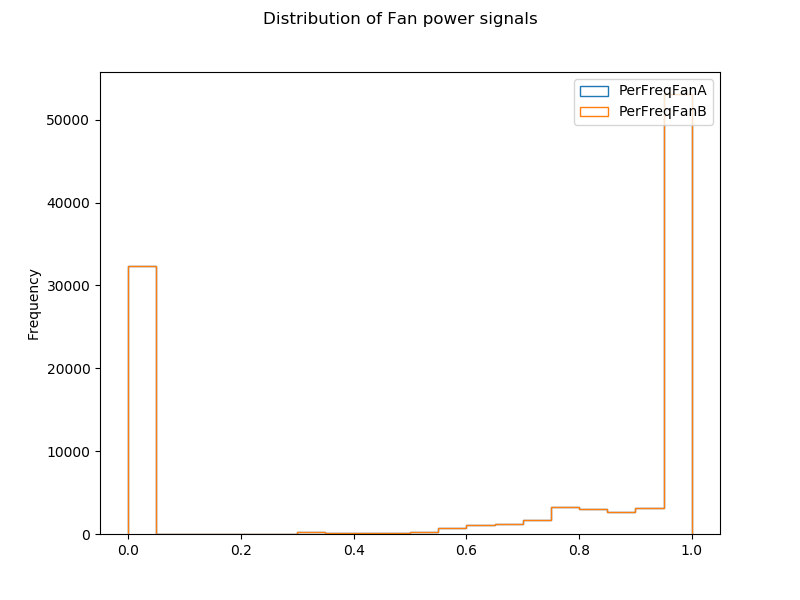

In [12]:
f = plt.figure(figsize=(8,6))
ax = f.add_subplot(111)
f.suptitle('Distribution of Fan power signals')
df['PerFreqFanA'].plot.hist(bins=20, legend=True, ax=ax, histtype='step')
df['PerFreqFanB'].plot.hist(bins=20, legend=True, ax=ax, histtype='step')
plt.savefig(path.join(plot_path, '6-fan-power-hist.png'))